<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/example_output/ArangoBnB_simple_data_exploration_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief Data Exploration of the Airbnb Dataset

This notebook showcases an example of data exploration as a part of a data modeling activity. The original dataset is pulled from and maintained by [insideAirbnb](http://insideairbnb.com/). The goal is to show a different approach to data analysis and exploration, compared to AQL. The approaches should not be considered contradictory but instead complimentary. This notebook focuses on some basic overview data and some insights into the prices of listings. A more complete look at the listings of the Airbnb dataset can be found in the original article.

This data was eventually used in the full stack JavaScript project, [ArangoBnB](https://github.com/cw00dw0rd/ArangoBnB). The ArangoBnB project has been created with the community and is always open to new contributors looking to learn more about ArangoDB, JavaScript, Vue, and/or React.

Some objectives for this data exploration activity includes:
 * Learn about the included fields and data types
 * Evaluate completeness of the fields
 * Determine if the data can fulfill our application requirements
 * Attempt to gain some quick insights from listing prices
 * Discover any necessary transformations

#### Application Requirements
The following is a list of application requirements that were previously outlined in the associated data modeling article. During the activity we hope to determine the viability of some of these features. It isn't likely that we will find all features listed in this single file but it's a good idea to keep them in mind.
 * Search an AirBnB dataset to find rentals nearby a specified location
 * A draggable map that shows results based on position
 * Use ArangoSearch to keep everything fast
 * Search the dataset with GeoJSON coordinates
 * Filter results based on keywords, price, guests, etc
 * Natural language search (Ex: Houses in Florida with pools.)
 * Use AQL for all queries
 * Multi-lingual support


## Install Prequisites

In [1]:
%%capture
!pip install python-arango
!pip install arangopipe==0.0.6.9.3
!pip install pandas

## Download the Data
Ideally, similar activities for each of the datasets would be performed and the collective insights would be used for development. For simplicity, this notebook will only look at a single collection, the `listings` collection. 

[insideAirbnb](http://insideairbnb.com/) provides two files named `listings`; one is essentially a summary of the larger file. The larger file is used in this example as it is only 40MB and provides a more complete view of the available data.

In [2]:
!wget "http://data.insideairbnb.com/germany/be/berlin/2020-12-21/data/listings.csv.gz"
!gunzip listings.csv.gz

--2021-06-01 17:33:52--  http://data.insideairbnb.com/germany/be/berlin/2020-12-21/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.72.163
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.72.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11736609 (11M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  11.19M  51.5MB/s    in 0.2s    

2021-06-01 17:33:53 (51.5 MB/s) - ‘listings.csv.gz’ saved [11736609/11736609]



## Read Data

Now that we have downloaded and unzipped the `listings.csv.gz` file for Berlin from [insideAirbnb](http://insideairbnb.com/get-the-data.html) we can start working with it.

To keep things easy we mostly stick with using [Pandas](https://pandas.pydata.org/docs/index.html) and [numPy](https://numpy.org/).

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("listings.csv", error_bad_lines=False)

## Generate Summaries
First, we look at the document's head and tail to see what fields exist and get a quick view of how the data looks.

Some immediate takeaways include:
 * Some values show `NaN`
 * Some fields contain HTML 
 * Price appears to be a string with symbols
 
Do you see anything else that needs attention?

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20201221044406,2020-12-22,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,Ion,2008-08-18,"Key Biscayne, Florida, United States",Isn’t sharing economy great?,within an hour,100%,96%,f,https://a0.muscache.com/im/pictures/user/21428...,https://a0.muscache.com/im/pictures/user/21428...,Mitte,7.0,7.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Germany",Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,0.0,"[""Refrigerator"", ""Coffee maker"", ""Hot water"", ...",$42.00,5,1125,3.0,11.0,1125.0,1125.0,6.1,1125.0,NaN,t,30,60,90,180,2020-12-22,134,4,0,2016-04-11,2020-09-26,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,6,6,0,0,2.34
1,3176,https://www.airbnb.com/rooms/3176,20201221044406,2020-12-21,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,https://www.airbnb.com/users/show/3718,Britta,2008-10-19,"Coledale, New South Wales, Australia",We love to travel ourselves a lot and prefer t...,within a few hours,83%,67%,f,https://a0.muscache.com/im/users/3718/profile_...,https://a0.muscache.com/im/users/3718/profile_...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53500,13.41758,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Kitchen"", ""Wifi"", ""Dedicated workspace"", ""Es...",$90.00,62,1125,62.0,62.0,1125.0,1125.0,62.0,1125.0,NaN,t,0,1,1,276,2020-12-21,146,1,0,2009-06-20,2020-05-27,93.0,9.0,9.0,9.0,9.0,10.0,9.0,NaN,f,1,1,0,0,1.04
2,3309,https://www.airbnb.com/rooms/3309,20201221044406,2020-12-22,BerlinSpot Schöneberg near KaDeWe,First of all:<br />I prefer short-notice booki...,"My flat is in the middle of West-Berlin, direc...",https://a0.muscache.com/pictures/29054294/b1fa...,4108,https://www.airbnb.com/users/show/4108,Jana,2008-11-07,"Berlin, Berlin, Germany",ENJOY EVERY DAY AS IF IT'S YOUR LAST!!! \r\n\r...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/d8049...,https://a0.muscache.com/im/pictures/user/d8049...,Schöneberg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,"Berlin, Germany",Schöneberg-Nord,Tempelhof - Schöneberg,52.49885,13.34906,Private room in apartment,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Wifi"", ""Dedicated workspace"", ""Free street p...",$29.00,7,35,7.0,7.0,35.0,35.0,7.0,35.0,Na

In [5]:
df.tail()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
20219,47150086,https://www.airbnb.com/rooms/47150086,20201221044406,2020-12-22,220m² Penthouse Apartment with Rooftop Terrace,"""This brand new apartment is located on the he...",NaN,https://a0.muscache.com/pictures/4d69015f-21a3...,20505065,https://www.airbnb.com/users/show/20505065,Michael,2014-08-25,"Berlin, Berlin, Germany",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/0124e...,https://a0.muscache.com/im/pictures/user/0124e...,NaN,0.0,0.0,"['phone', 'reviews', 'jumio', 'government_id']",t,t,NaN,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,52.51177,13.47091,Entire apartment,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Portable fans"", ""Nespresso machine"", ""Dryer""...",$197.00,7,1125,7.0,7.0,1125.0,1125.0,7.0,1125.0,NaN,t,28,37,37,37,2020-12-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
20220,47152254,https://www.airbnb.com/rooms/47152254,20201221044406,2020-12-22,Offline im Grünen,Offline im Grünen.<br />Hej zusammen! Ich verm...,NaN,https://a0.muscache.com/pictures/8d062f89-4130...,124202275,https://www.airbnb.com/users/show/124202275,Frank Daniel,2017-04-04,"Berlin, Berlin, Germany",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/aaea6...,https://a0.muscache.com/im/pictures/user/aaea6...,NaN,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Müggelheim,Treptow - Köpenick,52.42237,13.67157,Tiny house,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Kitchen"", ""Dedicated workspace"", ""Private en...",$79.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,29,40,40,40,2020-12-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
20221,47152724,https://www.airbnb.com/rooms/47152724,20201221044406,2020-12-22,"Helle stylische Altbau Wohnung, typisch Berlin",NaN,NaN,https://a0.muscache.com/pictures/079cf12a-d738...,23929693,https://www.airbnb.com/users/show/23929693,Satin,2014-11-19,"Wuppertal, North Rhine-Westphalia, Germany",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/23929693/prof...,https://a0.muscache.com/im/users/23929693/prof...,NaN,1.0,1.0,"['phone', 'jumio', 'offline_government_id', 's...",t,t,NaN,südliche Luisenstadt,Friedrichshain-Kreuzberg,52.49752,13.44641,Earth house,Entire home/apt,3,NaN,1 bath,2.0,2.0,"[""Kitchen"", ""Wifi"", ""Dedicated workspace"", ""Ho...",$45.00,7,21,7.0,7.0,21.0,21.0,7.0,21.0,NaN,t,20,20,20,20,2020-12-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
20222,47153362,https://www.airbnb.com/rooms/47153362,20201221044406,2020-12-22,Eckneubauwohnung am Paul-Lincke-Ufer,"Hochwertig ausgestattete (Bosch-Küche, Fischgr...",NaN,https://a0.muscache.com/pictures/c4939d39-3fa6...,376835125,https://www.airbnb.com/users/show/3768351

We can get an idea of the data types for the various fields with the [info()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method which prints a summary of the dataframe. 
This summary includes:
 * Field(column) name
 * The number of non-null values
 * The field datatype

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20224 non-null  int64  
 1   listing_url                                   20224 non-null  object 
 2   scrape_id                                     20224 non-null  int64  
 3   last_scraped                                  20224 non-null  object 
 4   name                                          20192 non-null  object 
 5   description                                   19671 non-null  object 
 6   neighborhood_overview                         10945 non-null  object 
 7   picture_url                                   20224 non-null  object 
 8   host_id                                       20224 non-null  int64  
 9   host_url                                      20224 non-null 

A common method to start with is [describe()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) which generates descriptive statistics. This method may be more appropriate for other datasets but still provides some interesting stats that gets us a little more familiar with the data.

For instance, values like `id`, `scrape_id`, `host_id`, 

In [7]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.022400e+04,2.022400e+04,2.022400e+04,20186.000000,20186.000000,20224.000000,20224.000000,20224.000000,0.0,18504.000000,19960.000000,20224.000000,20224.000000,20217.000000,20217.000000,20217.000000,2.021700e+04,20217.000000,2.021700e+04,0.0,20224.000000,20224.000000,20224.000000,20224.000000,20224.000000,20224.000000,20224.000000,15759.000000,15739.000000,15740.000000,15725.000000,15737.000000,15727.000000,15724.000000,20224.000000,20224.000000,20224.000000,20224.000000,16164.000000
mean,2.410549e+07,2.020122e+13,8.776288e+07,4.040672,4.040672,52.510307,13.404670,2.751879,NaN,1.281236,1.663778,8.256725,594.016762,8.051392,8.669536,701.755948,2.131532e+05,8.372696,1.948836e+05,NaN,8.496638,18.444373,29.152195,95.629450,22.388894,3.346025,0.084355,94.609049,9.672088,9.332402,9.738315,9.739086,9.613149,9.403269,2.983386,1.995550,0.706141,0.180281,0.753390
std,1.402893e+07,5.675922e+00,1.012863e+08,31.107750,31.107750,0.031884,0.062131,1.655323,NaN,0.779072,1.604527,30.048558,541.025338,29.860593,31.192204,555.492830,2.135874e+07,30.145679,1.952247e+07,NaN,11.992580,24.782948,37.791545,133.168147,48.541962,8.476980,0.721869,8.053667,0.789620,1.039192,0.718623,0.726902,0.747730,0.880650,7.103025,6.488426,1.295231,2.234937,1.234713
min,2.015000e+03,2.020122e+13,1.581000e+03,0.000000,0.000000,52.340410,13.098390,0.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.197718e+07,2.020122e+13,1.091632e+07,1.000000,1.000000,52.489787,13.368557,2.000000,NaN,1.000000,1.000000,2.000000,25.750000,2.000000,2.000000,30.000000,3.000000e+01,2.000000,3.000000e+01,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.100000
50%,2.310571e+07,2.020122e+13,4.185637e+07,1.000000,1.000000,52.509960,13.414120,2.000000,NaN,1.000000,1.000000,3.000000,392.500000,3.000000,3.000000,1125.000000,1.125000e+03,3.000000,1.125000e+03,NaN,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.310000
75%,3.722716e+07,2.020122e+13,1.355188e+08,2.000000,2.000000,52.533090,13.438930,4.000000,NaN,1.000000,2.000000,5.000000,1125.000000,5.000000,5.000000,1125.000000,1.125000e+03,5.000000,1.125000e+03,NaN,20.000000,49.000000,77.000000,178.000000,19.000000,3.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,0.890000
max,4.715673e+07,2.020122e+13,3.808356e+08,1111.000000,1111.000000,52.655980,13.757580,16.000000,NaN,50.000000,96.000000,1124.000000,9999.000000,1124.000000,1124.000000,9999.000000,2.147484e+09,1124.000000,1.962858e+09,NaN,30.000000,60.000000,90.000000,365.000000,620.000000,202.000000,79.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,72.000000,72.000000,13.000000,38.000000,66.360000


In [8]:
df.isna().any()

id                                              False
listing_url                                     False
scrape_id                                       False
last_scraped                                    False
name                                             True
                                                ...  
calculated_host_listings_count                  False
calculated_host_listings_count_entire_homes     False
calculated_host_listings_count_private_rooms    False
calculated_host_listings_count_shared_rooms     False
reviews_per_month                                True
Length: 74, dtype: bool

In [9]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
20219    False
20220    False
20221    False
20222    False
20223    False
Length: 20224, dtype: bool

## Listing Price Insights

In [10]:
# Converts price from string to number and removes special characters
df['price'] = df["price"].replace('[\$\,]',"",regex=True).astype(float)

# Sets sensible tick range for prices
# Eventually isn't necessary as setting c and colormap does this for us
ticks = np.arange(min(df['price']) ,max(df['price']), (max(df['price']) / 25))

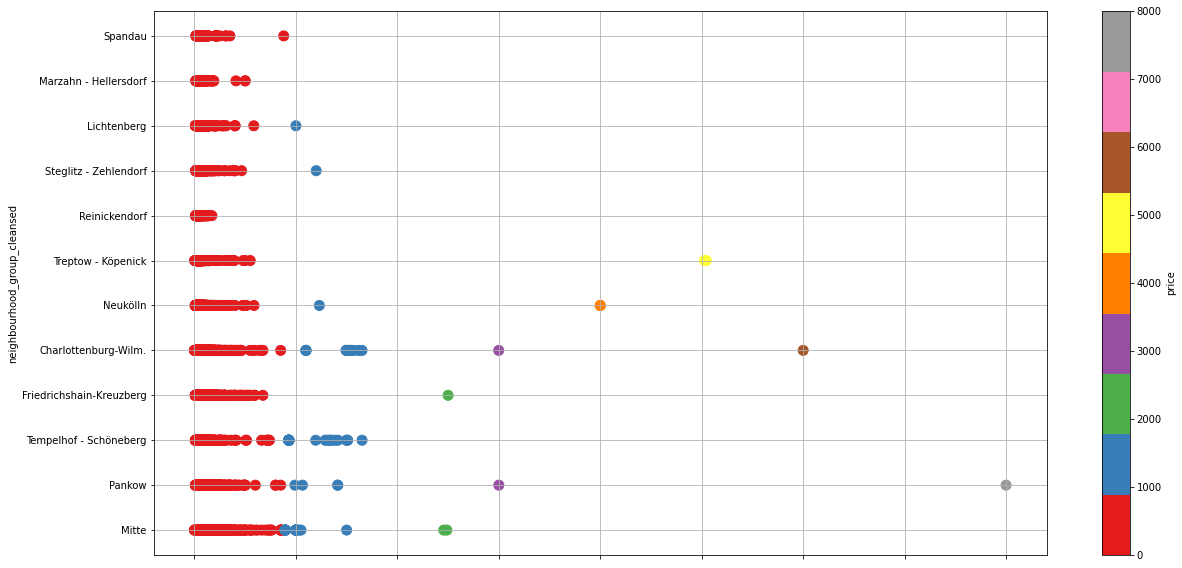

In [11]:
plt = df.plot(x="price", y="neighbourhood_group_cleansed", s=100, kind="scatter", c="price", colormap='Set1', figsize=[20, 10], grid=True)

This seems to be indicating that there are prices reaching 8000?

Using [max()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html) we can confirm this, as well as get some insights into other fields.
Some interesting fields:
 * The max number of bedrooms is 50!
 * The max number of beds is 96!
 * The min/max nights seem to have some outliers of 1124/9999
 * The max review score is 10 in all categories 

In [12]:
df.max()

id                                                                                       47156730
listing_url                                                  https://www.airbnb.com/rooms/9996186
scrape_id                                                                          20201221044406
last_scraped                                                                           2020-12-30
picture_url                                     https://a0.muscache.com/pictures/pro_photo_too...
host_id                                                                                 380835644
host_url                                               https://www.airbnb.com/users/show/99993828
host_listings_count                                                                          1111
host_total_listings_count                                                                    1111
host_verifications                                                                             []
neighbourhood_cleans

In [13]:
# Of the 22k listings, there are 430 different prices set
len(pd.unique(df['price']))

430

This has been a quick look at using pandas to explore data.
In this notebook we:
 * Gained an overview of the available data and their types
 * Got some insights into neighborhoods and prices
 * Transformed the price from a string into a useable number
 